In [1]:
import numpy as np
import pyhf
import yaml
from pyik.numpyext import rebin
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from scipy.interpolate import interp1d
import matplotlib as mtlp
from pyik.mplext import plot_hist
from scipy.stats import norm, poisson,chi2
from scipy.interpolate import splev, splrep
from pyik.numpyext import rebin
import mplhep as hep
from matplotlib import rc
rc('text', usetex=True)
warnings.filterwarnings("ignore")
pyhf.set_backend("numpy")
filename ="./data.yaml"
stream = open(filename, 'r')
data = yaml.safe_load(stream)

In [17]:
## Some functions 

LambdaNP=1e+3  #GeV
v= 246.
mh=125.1
mass ={
'ku':2.2e-3,
'kd':4.7e-3,
'ks':95e-3,
'kc':1.275,
}

def kqtoCqH(kq,op):
    if op=='ku'or op=='kd'or op=='ks' or  op=='kc':
        return LambdaNP**2/v**3*(np.sqrt(2.0)*mass[op]*(1-kq))
    else:
        return kq



def CqHtokq(CqH,op):
    if op=='ku'or op=='kd'or op=='ks' or  op=='kc':
        return -(CqH/np.sqrt(2)/LambdaNP**2 *v**3/mass[op])+1
    else:
        return CqH
def CHtokl(CH):
    return 1-2.0*CH*v**4/mh**2/LambdaNP**2

def kltoCH(kl):
    return LambdaNP**2/v**4*mh**2*0.5*(1-kl)
######################################################################
def invert_interval(test_mus, hypo_tests, test_size=0.05):
    cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
    cls_exp = [
        np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)
    ]
    crossing_test_stats = {"exp": [], "obs": None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats["exp"].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats["obs"] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats
######################################################################

def XS(CqH,f,W):
    kq=CqHtokq(CqH,f)
    R=data[f][W]['XSA0']+data[f][W]['XSA1']*kq+data[f][W]['XSA2']*kq**2
    return R*data['kl'][W]['XSSM']- data['kl'][W]['XSSM']

def BR(CqH,f):
    kq=CqHtokq(CqH,f)
    Rga= data[f]['Width']['gagaA0']+ data[f]['Width']['gagaA1']*kq+data[f]['Width']['gagaA2']*kq**2
    Rtot= data[f]['Width']['totA0']+ data[f]['Width']['totA1']*kq+data[f]['Width']['totA2']*kq**2
    HiggsFullwidth = data['Higgs']['width']*Rtot
    return 2*(data['Higgs']['BRbbSM']*Rga*data['Higgs']['BRgagaSM'])/Rtot


def plot_result(ax,obs_scan_res,kk,W,op,CL):
    label_dict ={
    'ku':'C_{uH}',
    'kd':'C_{dH}',
    'ks':'C_{sH}',
    'kc':'C_{cH}',
    'cu':'c_u',
    'cuu':'c_{uu}',
    'cd':'c_d',
    'cdd':'c_{dd}',
    'cs':'c_s',
    'css':'c_{ss}',
    'cc':'c_c',
    'ccc':'c_{cc}',
    'kl' :'\kappa_\lambda'
    }
    etck=  splrep(kk, obs_scan_res[:,2],s=0)
    p1_sig_tck= splrep(kk, obs_scan_res[:,3],s=0)
    m1_sig_tck= splrep(kk, obs_scan_res[:,1],s=0)
    p2_sig_tck=splrep(kk, obs_scan_res[:,4],s=0)
    m2_sig_tck= splrep(kk, obs_scan_res[:,0],s=0)
    
    

    ax.set_xlabel(r"$%s$[$\mathrm{TeV}^{-2}$]"%(label_dict[op]))
    ax.set_ylabel(r"$\sigma \cdot \mathrm{BR}_{b \bar b \gamma \gamma }$ @ %d %sCL [fb]"%(CL, '\%'))
    s= kk[-1]

    x= np.linspace(kk[0],kk[-1], 500)
    xx=np.linspace(kk[0],kk[-1], 1000)
    
    expec=splev(x,etck)
    p1_sig= splev(x,p1_sig_tck)
    p2_sig =splev(x,p2_sig_tck)
    m2_sig =splev(x,m2_sig_tck)
    m1_sig =splev(x,m1_sig_tck)
    
    
    
    XSr= lambda y: (XS(y,op,"%dTeV"%(W))+data['kl']["%dTeV"%(W)]['XSSM'])*BR(y,op)


    plt.fill_between(x,XSr(x)*m2_sig,XSr(x)*p2_sig,facecolor='y',alpha=0.5 , label =r"$\pm 2 \sigma$")
    #
    plt.fill_between(x,XSr(x)*m1_sig,XSr(x)*p1_sig,facecolor='g',alpha=0.5 , label =r"$\pm 1 \sigma$")
    #####
    plt.plot(x,XSr(x)*expec,color='k',ls='--',lw=1.5, label="Expected" )
    ###
    plt.plot(xx,XSr(xx),lw=1.5, label="Theory" ,color='#31455b')
    plt.fill_between(xx,XSr(xx)*0.95,XSr(xx)*1.05,facecolor='#31455b',alpha=0.5)

    ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
    ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
    plt.xlim(x[0],x[-1])
    plt.grid(ls=':',color='#808080')
    plt.legend()

In [12]:
eff ={
'ku':0.161,
'kd': 0.162
}


def sig_lambda(kl,kq):
    return np.array([lfbin1(kl), lfbin2(kl),lfbin3(kl),lfbin4(kl),lfbin5(kl)]) *aux.BR(aux.kqtoCqH(kq,op),op)*L*btageff
def sig(kq):
    return XS(kqtoCqH(kq,op),op,"%dTeV"%(W))*BR(kqtoCqH(kq,op),op)*L* eff[op]



def scan(CqH,CH):
    kq=CqHtokq(CqH,op)
    kl=CHtokl(CH)
    signal_d= [sig(kq)+44.0*L/6000] 
    bkg_d= [(89+83+700)*L/6000] 
    bkg_un_d=[0.02*(89+83+700)*L/6000]
    
    model = pyhf.simplemodels.hepdata_like(
        signal_data=signal_d, bkg_data=bkg_d, bkg_uncerts=bkg_un_d
    )
# mu' = 0: background-like
    pars_bkg = model.config.suggested_init()
    pars_bkg[model.config.poi_index] = 0.0
    # mu' = 1: signal-like
    pars_sig = model.config.suggested_init()
    pars_sig[model.config.poi_index] = 1.0

    # data = model.expected_data(model.config.suggested_init())
    data=  pyhf.tensorlib.astensor(bkg_d + model.config.auxdata)

    poi_vals = np.linspace(0, 5.0, 50)
    # print(model.config.suggested_bounds())
    results = [
        pyhf.infer.hypotest(test_poi,
        data,
        model,
        model.config.suggested_init(),
        # par_bounds=[(0, 30), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0), (1e-10, 30.0)],
        qtilde=True,
        return_expected_set=True)
        for test_poi in poi_vals
    ]
    invresults = invert_interval(poi_vals, results,test_size= 1-CL*1e-2) # 0.32 , 0.05,0.003
    expec=invresults['exp']
    return expec

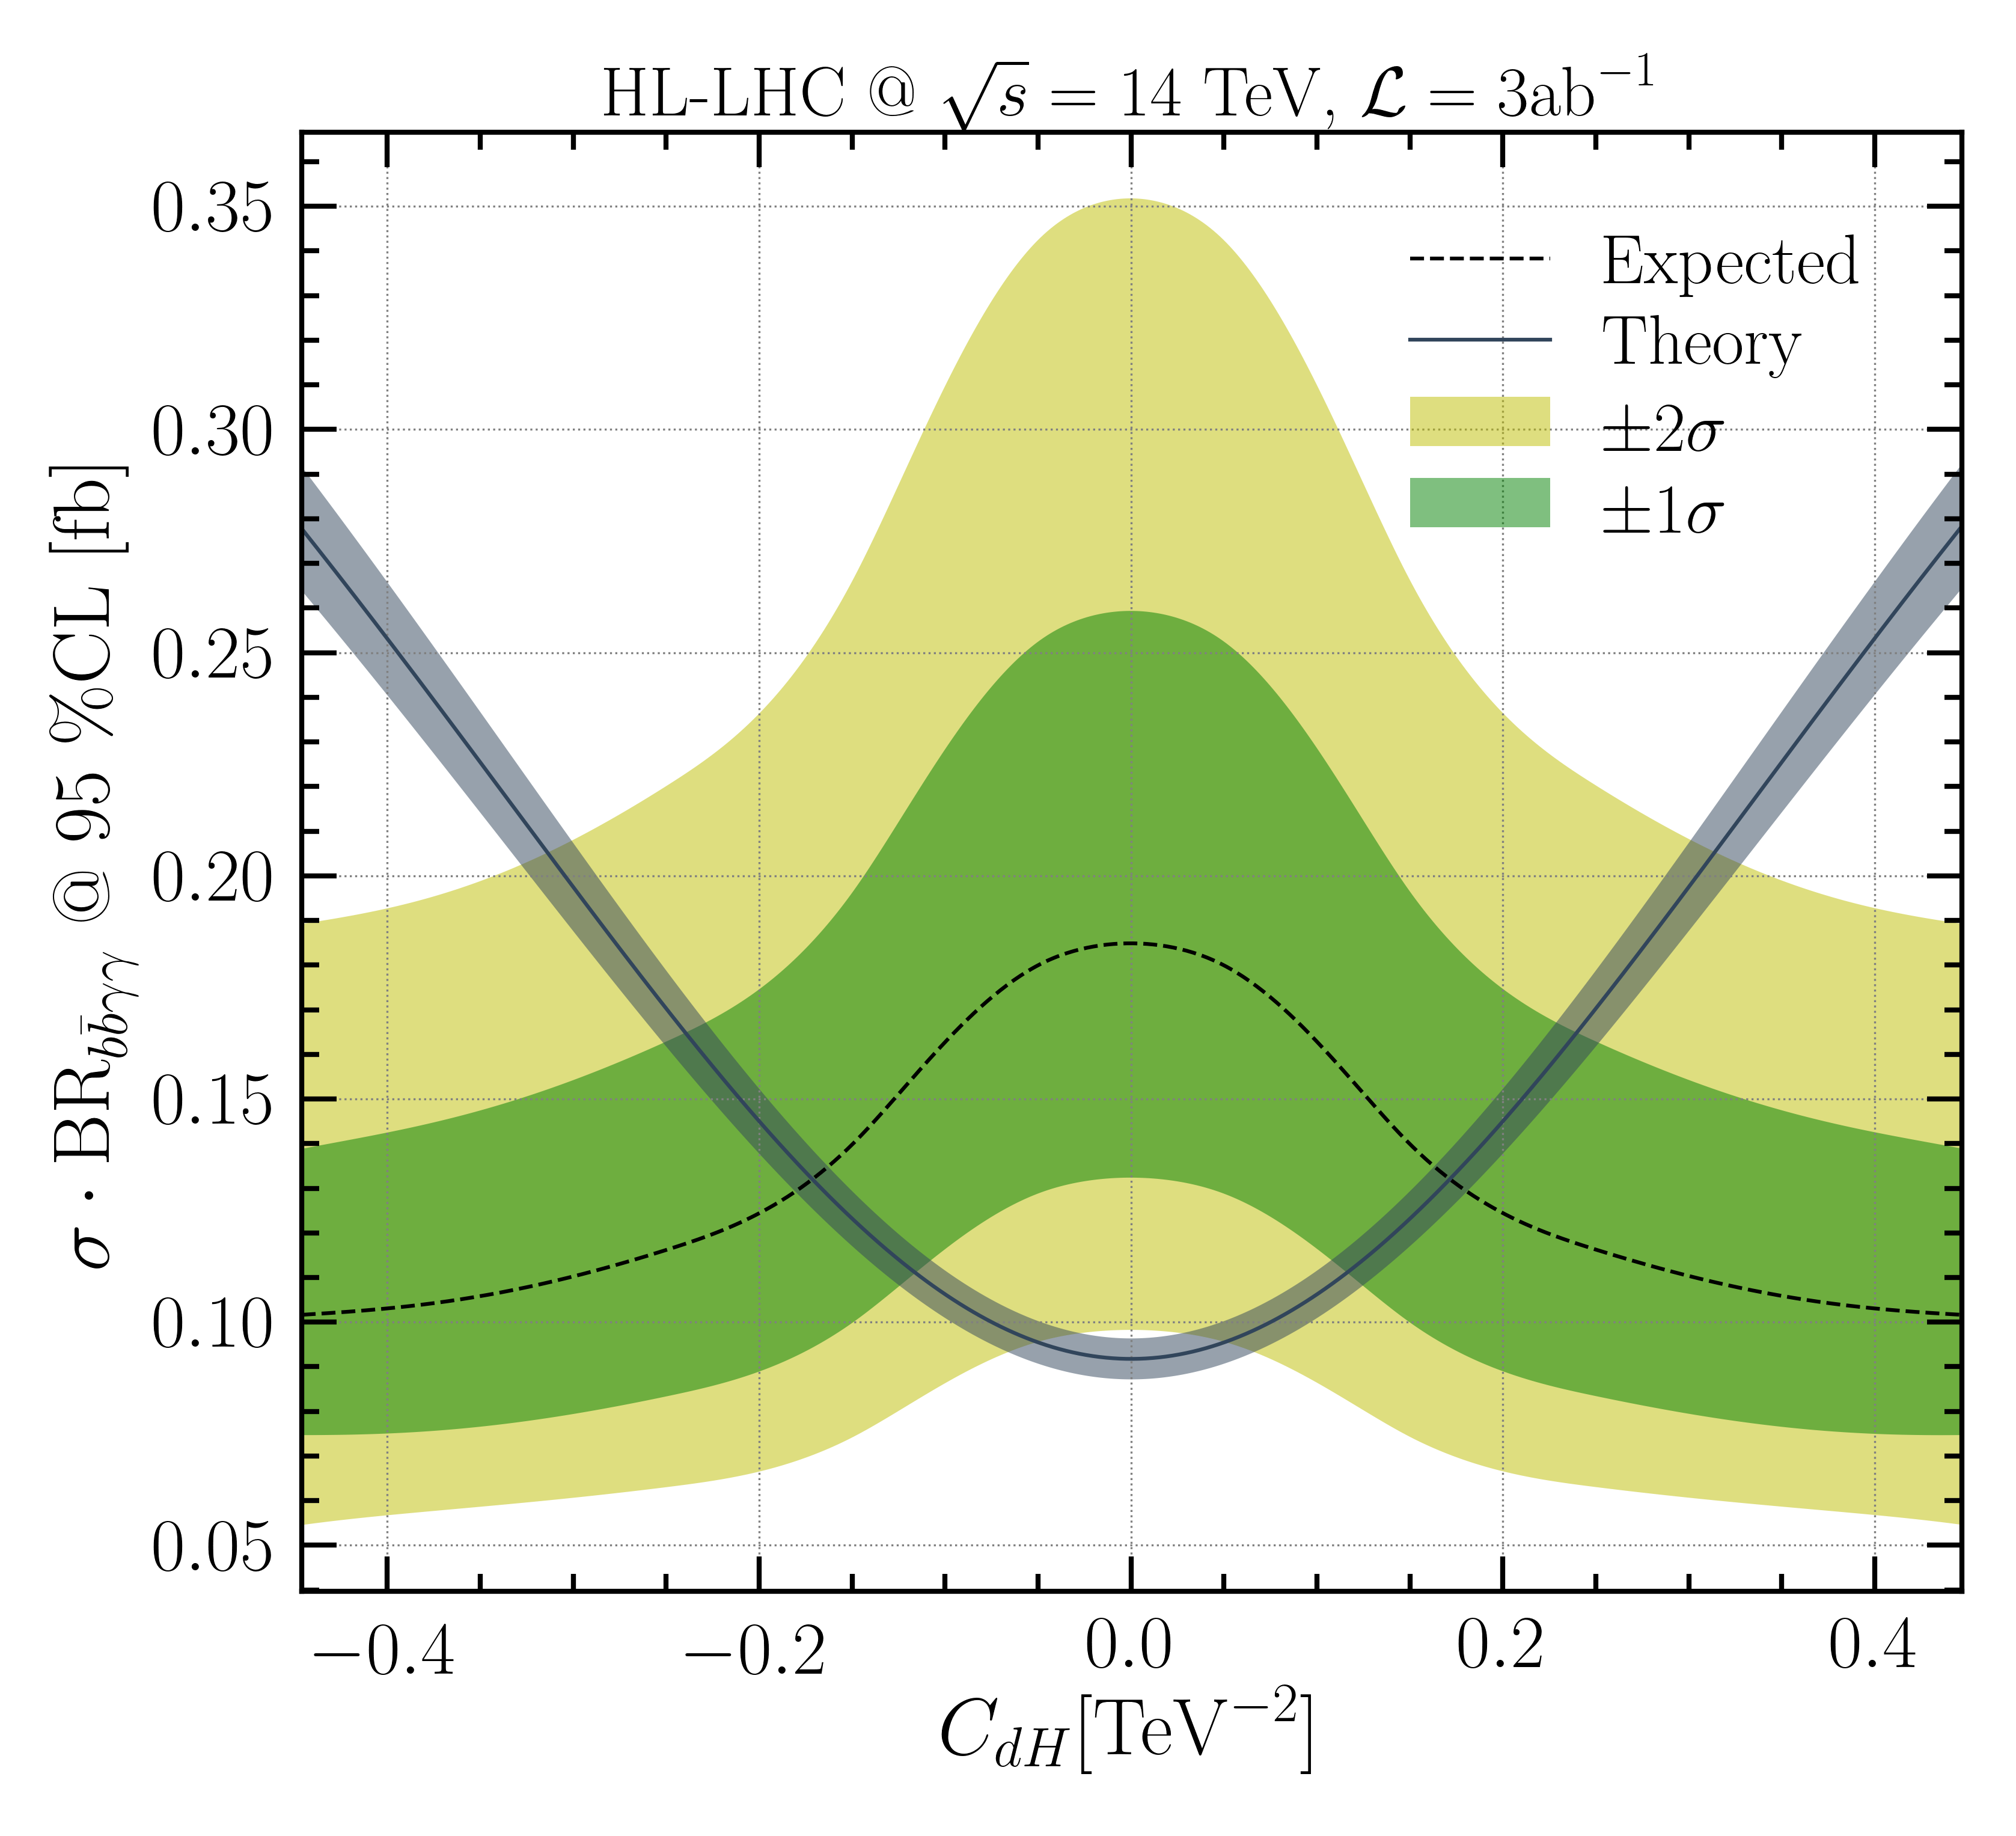

In [18]:
W = 14  # TeV  COM energy
op= "kd"      # quark flavour
flav = 'down'
L= 3000.00   #inv fb
CL = 95 #  68% (1 sigma), 95% (2 sigma) and 99.7 % (3 sigma)
kkq =np.linspace(kqtoCqH(1000,op),kqtoCqH(-1000,op), 10) # put them backwards 


obs_scan_res= np.array([
scan(k,0.0) for k in kkq
 ])

plt.style.use(hep.style.LHCb2)
fig, ax = plt.subplots(1, figsize=(11, 10))
plot_result(ax,obs_scan_res,kkq,W,op,CL)

plt.title(r"HL-LHC @ $\sqrt{s}=%d$ TeV, $\mathcal L= %d \mathrm{ab}^{-1}$"%(W,L/1000))

plt.gcf().tight_layout()

plt.show()

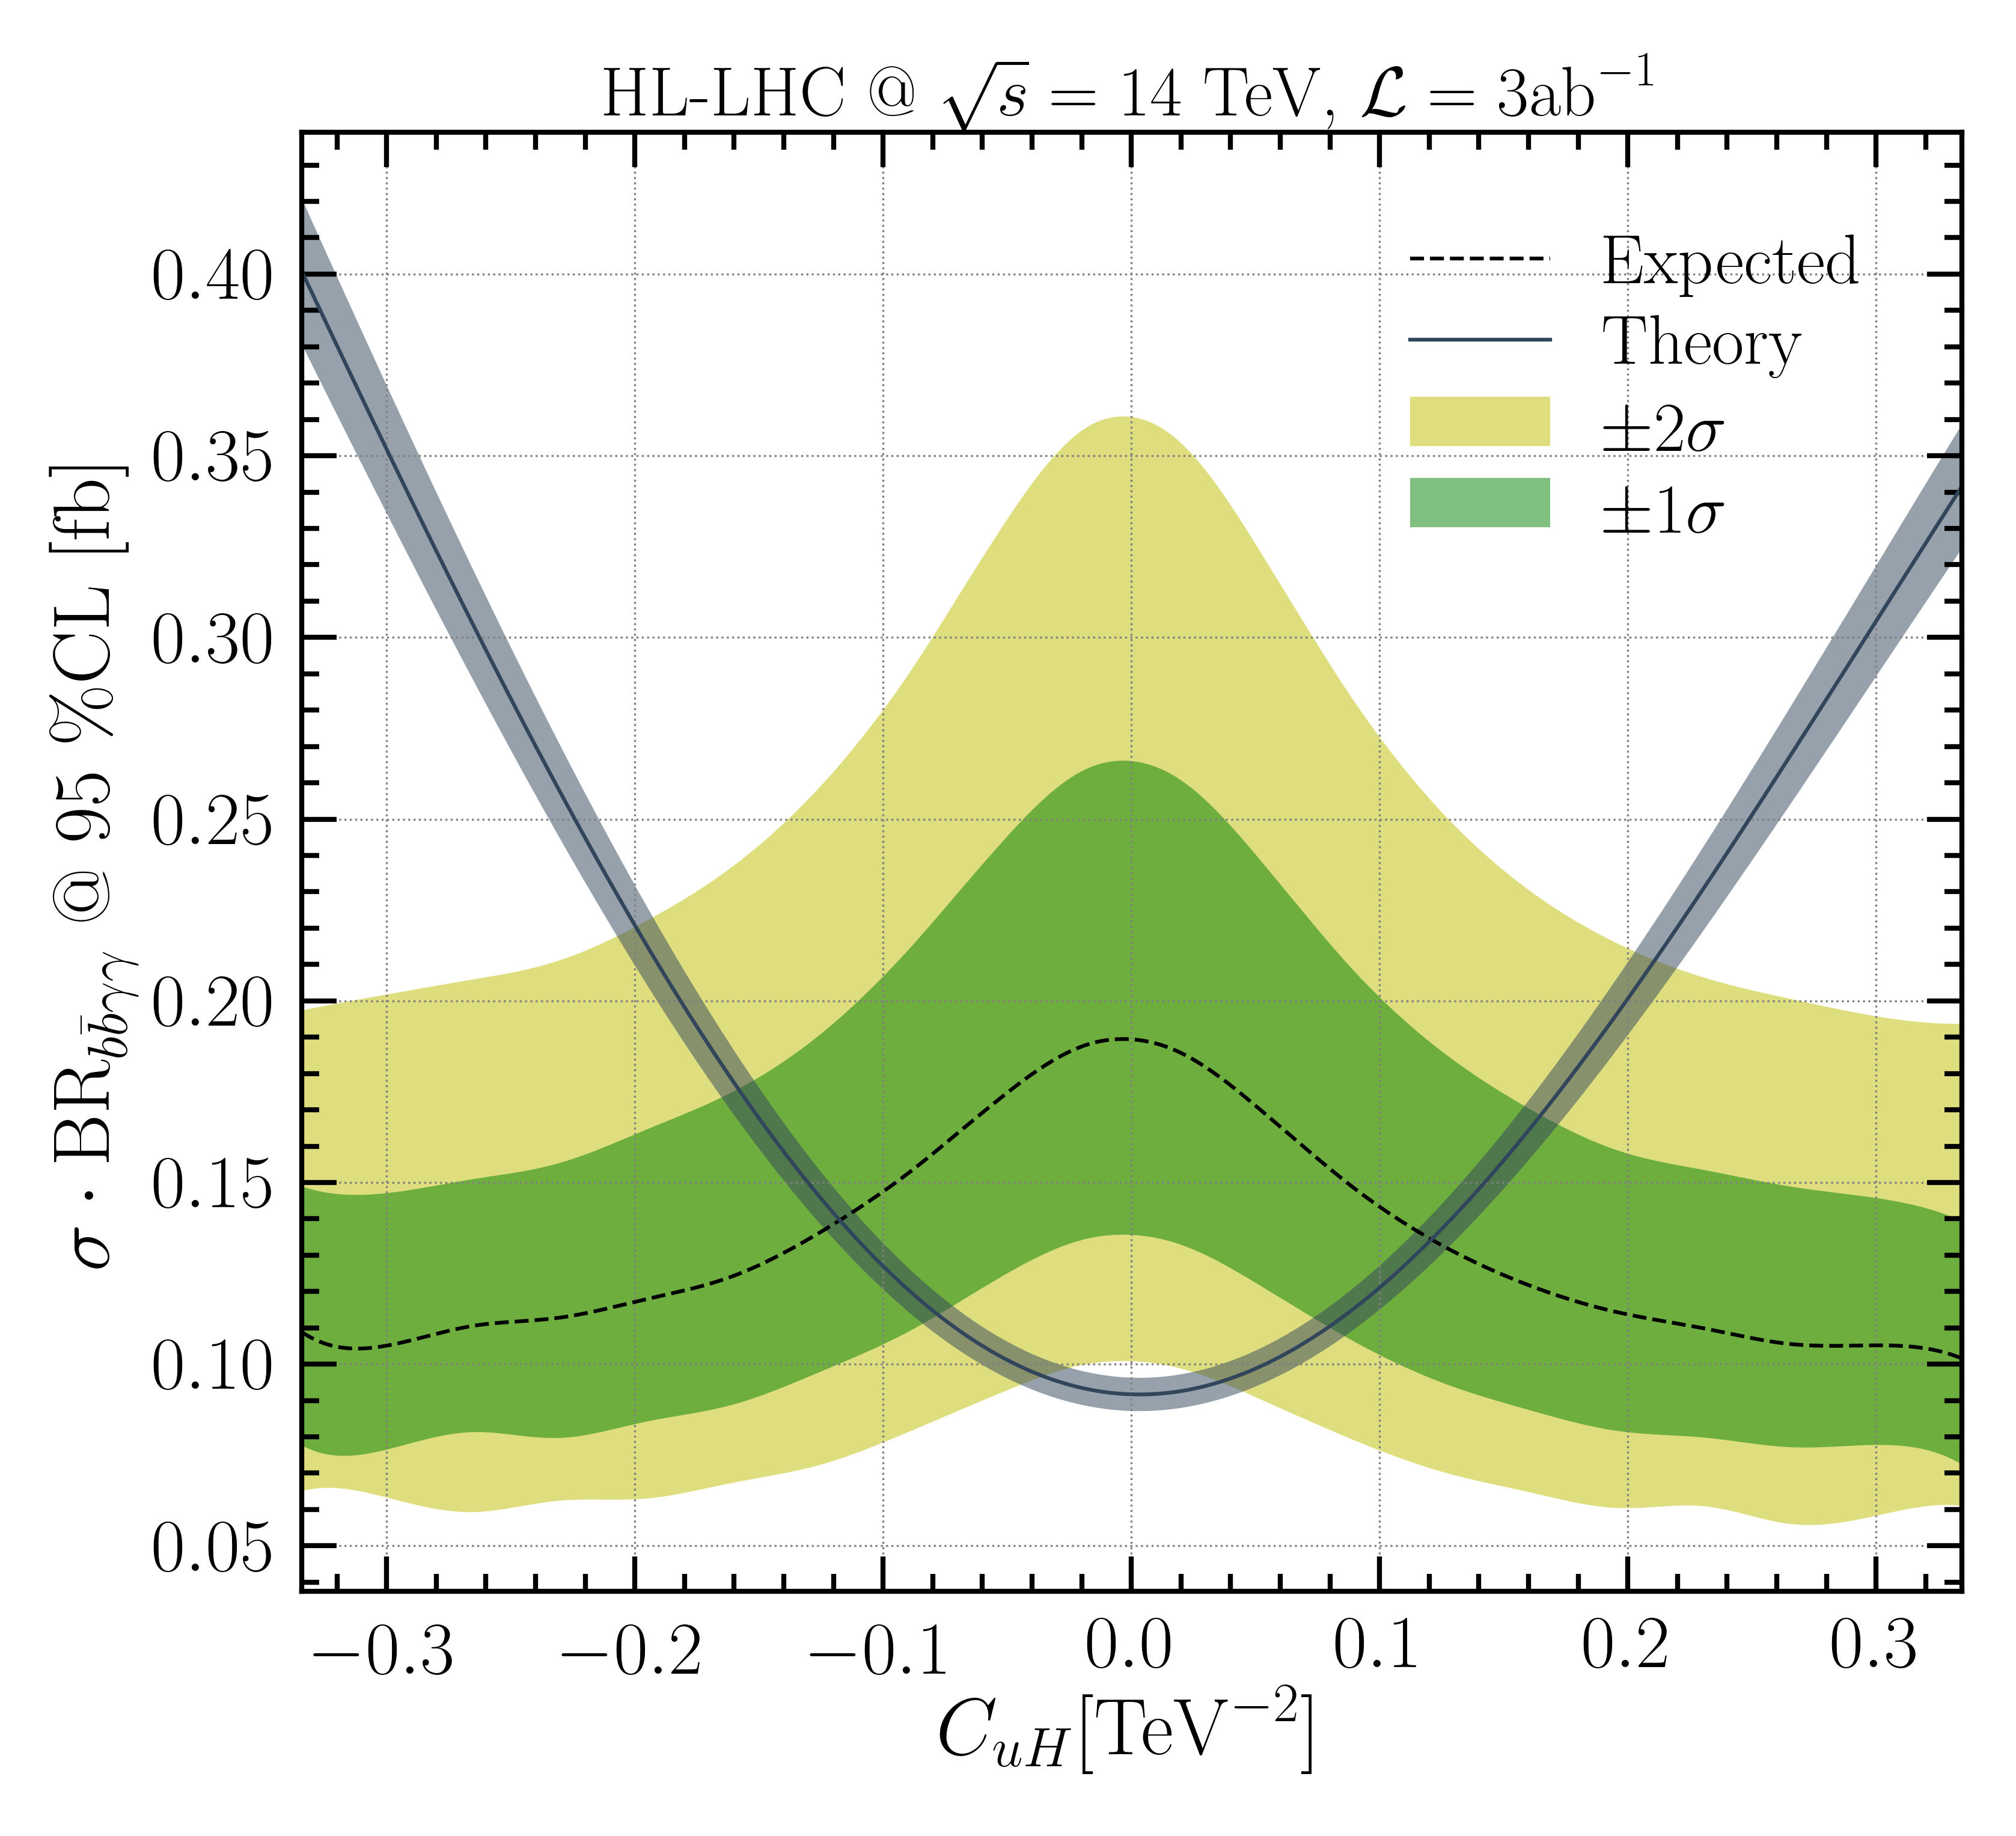

In [21]:
W = 14  # TeV  COM energy
op= "ku"      # quark flavour
flav = 'up'
L= 3000.00   #inv fb
CL = 95 #  68% (1 sigma), 95% (2 sigma) and 99.7 % (3 sigma)
kkq =np.linspace(kqtoCqH(1600,op),kqtoCqH(-1600,op), 20) # put them backwards 

obs_scan_res= np.array([
scan(k,0.0) for k in kkq
 ])

plt.style.use(hep.style.LHCb2)
fig, ax = plt.subplots(1, figsize=(11, 10))
plot_result(ax,obs_scan_res,kkq,W,op,CL)

plt.title(r"HL-LHC @ $\sqrt{s}=%d$ TeV, $\mathcal L= %d \mathrm{ab}^{-1}$"%(W,L/1000))

plt.gcf().tight_layout()

plt.show()